In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from yellowbrick.classifier import ROCAUC
import xgboost as xgb
import joblib

In [2]:
df = pd.read_csv('../data/raw/diabetes.csv')
print(df.shape)
df.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# EDA

### Data inspection

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Search for null values

In [5]:
(df.isnull().sum()/len(df)) * 100

Pregnancies                 0.0
Glucose                     0.0
BloodPressure               0.0
SkinThickness               0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
Outcome                     0.0
dtype: float64

### Data visualization

<AxesSubplot:>

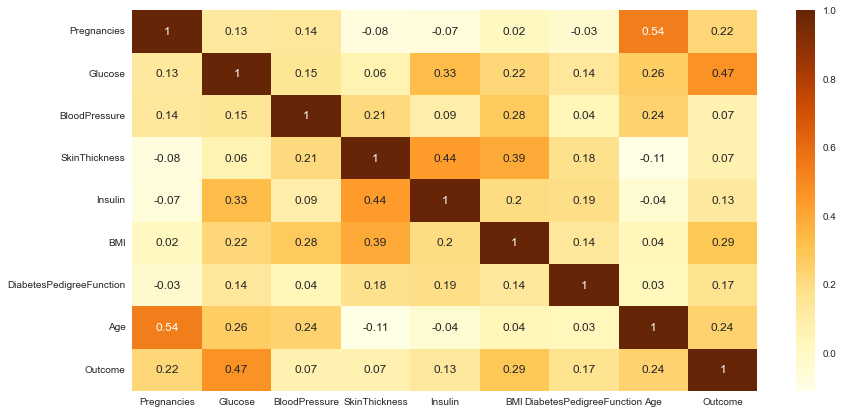

In [6]:
corr = df.corr().round(2)
plt.figure(figsize = (14,7))
sns.heatmap(corr, annot = True, cmap = 'YlOrBr')

<AxesSubplot:xlabel='Outcome', ylabel='count'>

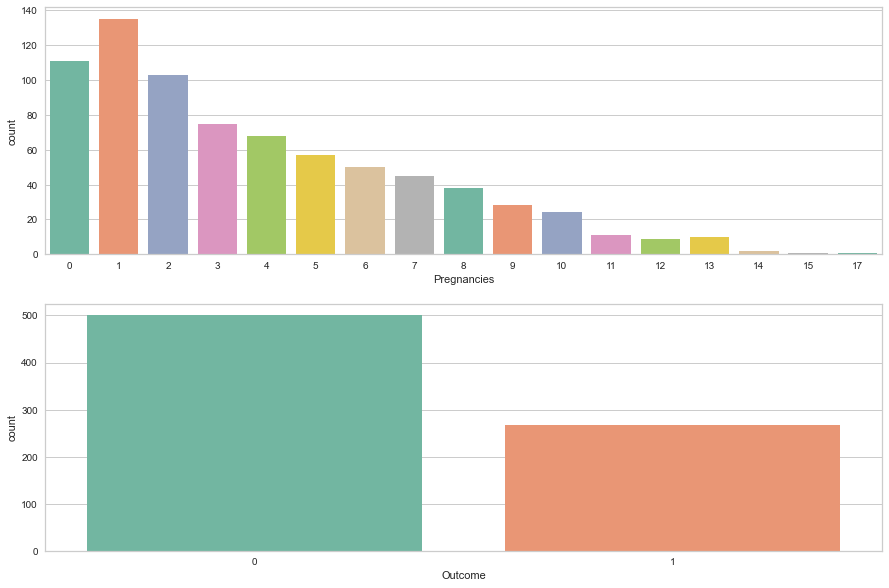

In [7]:
plt.figure(figsize = (15,10))

plt.subplot(2,1,1)
sns.countplot(x = 'Pregnancies', palette = 'Set2', data = df)

plt.subplot(2,1,2)
sns.countplot(x = 'Outcome', palette = 'Set2', data = df)

<AxesSubplot:xlabel='Age', ylabel='Count'>

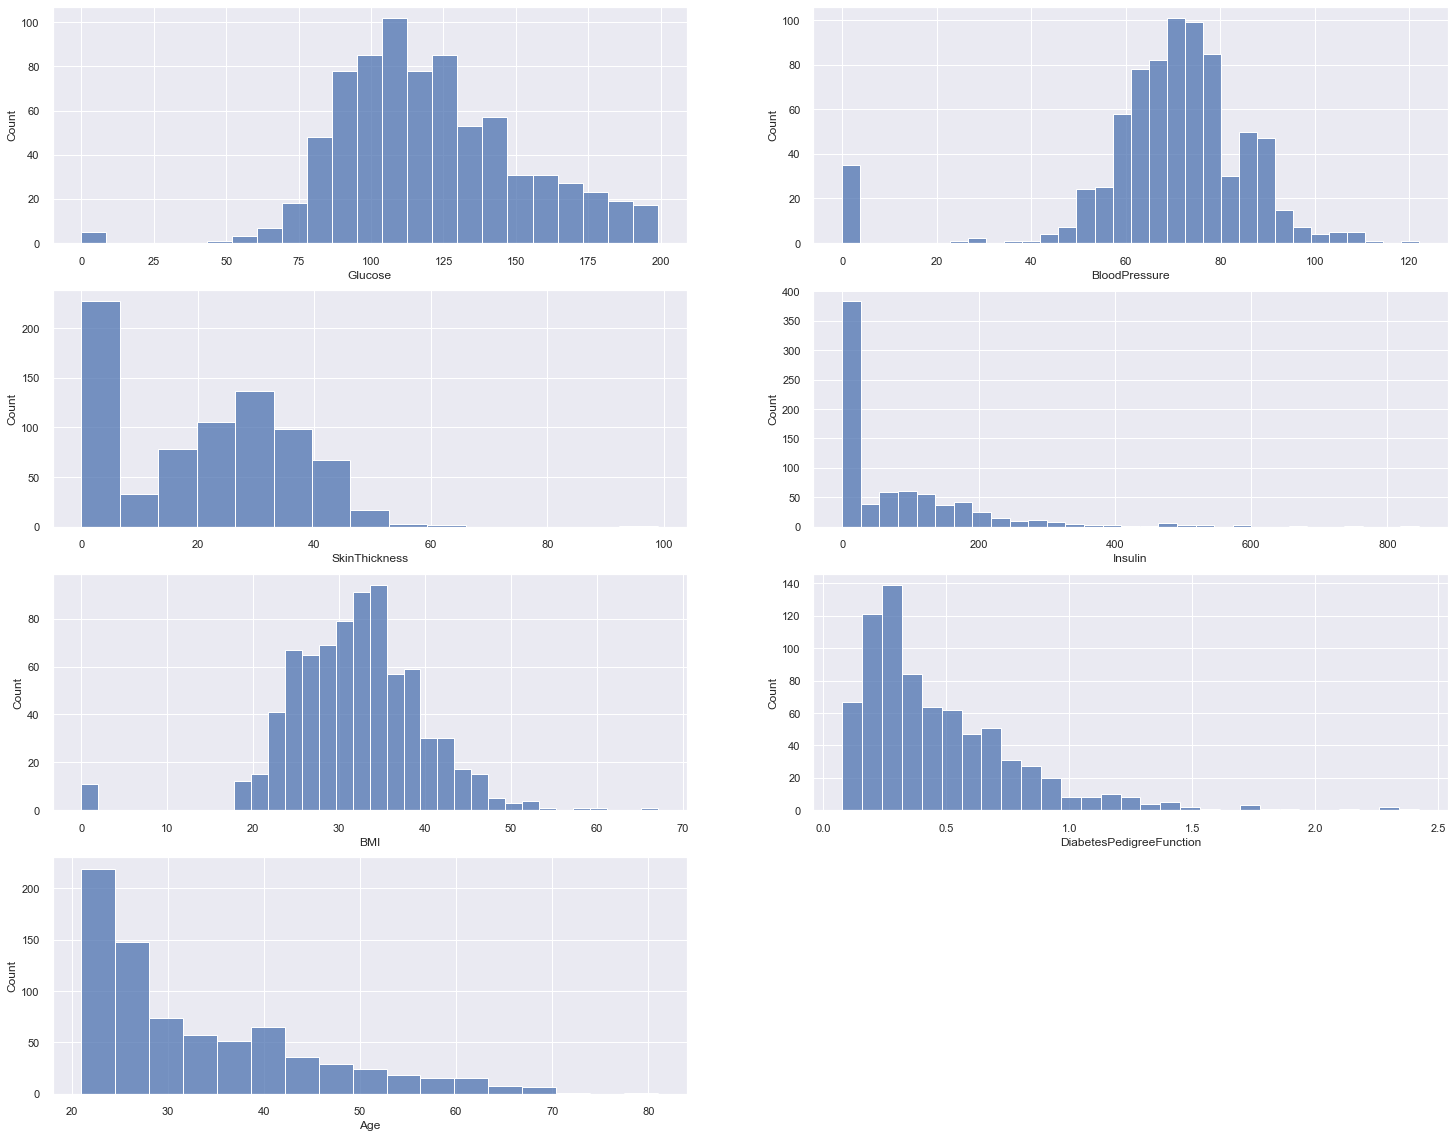

In [12]:
plt.figure(figsize = (25,20))
sns.set(color_codes = True)

plt.subplot(4,2,1)
sns.histplot(df['Glucose'], kde = False)

plt.subplot(4,2,2)
sns.histplot(df['BloodPressure'], kde = False)

plt.subplot(4,2,3)
sns.histplot(df['SkinThickness'], kde = False)

plt.subplot(4,2,4)
sns.histplot(df['Insulin'], kde = False)

plt.subplot(4,2,5)
sns.histplot(df['BMI'], kde = False)

plt.subplot(4,2,6)
sns.histplot(df['DiabetesPedigreeFunction'], kde = False)

plt.subplot(4,2,7)
sns.histplot(df['Age'], kde = False)

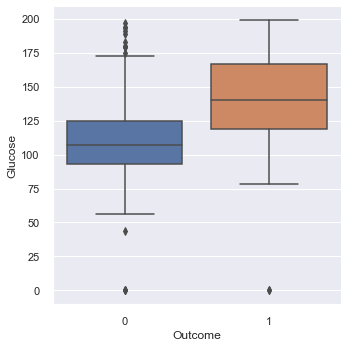

In [9]:
sns.catplot(x = 'Outcome', y="Glucose", kind="box", data = df)

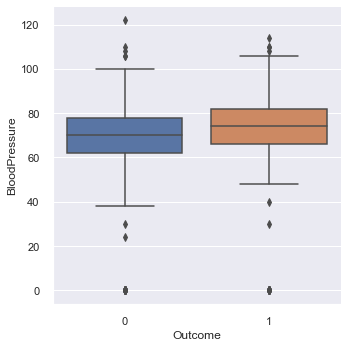

In [10]:
sns.catplot(x = 'Outcome', y="BloodPressure", kind="box", data = df)

### Data cleaning

Dropping columns with low correlation

In [4]:
df_proc = df.drop(columns=['BloodPressure', 'SkinThickness'])
df_proc.head()

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,0,33.6,0.627,50,1
1,1,85,0,26.6,0.351,31,0
2,8,183,0,23.3,0.672,32,1
3,1,89,94,28.1,0.167,21,0
4,0,137,168,43.1,2.288,33,1


# Modeling

In [5]:
class ML_evaluation:
  def __init__(self, X_train, y_train, X_test, y_test, model, label_dict):
    self.X_train = X_train
    self.y_train = y_train
    self.X_test = X_test
    self.y_test = y_test
    self.model = model
    self.label_dict = label_dict
    self.y_pred = self.model.predict(self.X_test)

  def class_report(self):
    print(classification_report(self.y_test, self.y_pred))
  
  def conf_matrix(self):
    results = pd.DataFrame({'Predict':self.y_pred,'Target': self.y_test})
    cm = confusion_matrix(y_pred=results['Predict'], y_true=results['Target'])
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cmn,annot=True,xticklabels=self.label_dict.values()
                ,yticklabels=self.label_dict.values(),cmap='plasma')
    plt.xlabel('Predicted')
    plt.ylabel('Target')
    plt.show()
  
  def plot_roc_curve(self):
    # Creating visualization with the readable labels
    visualizer = ROCAUC(self.model, encoder=self.label_dict)
                                      
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(self.X_train, self.y_train)
    visualizer.score(self.X_test, self.y_test)
    visualizer.show()

  def save_model(self, filename):
    joblib.dump(self.model, filename)

  def eval_all(self):
    print("Classification Report")
    self.class_report()

    print("\nConfusion Matrix")
    self.conf_matrix()

    print("\nROC Curve")
    self.plot_roc_curve()


In [6]:
X = df_proc.drop('Outcome', axis = 1)
X = X.values
y = df_proc['Outcome']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
print(X_train.shape, y_train.shape)

(576, 6) (576,)


In [8]:
xgbc=xgb.XGBClassifier(max_depth=2, n_estimators=50, objective='binary:logistic', seed=0, subsample=.8, scale_pos_weight=2)
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       130
           1       0.64      0.79      0.71        62

    accuracy                           0.79       192
   macro avg       0.77      0.79      0.77       192
weighted avg       0.81      0.79      0.80       192


Confusion Matrix


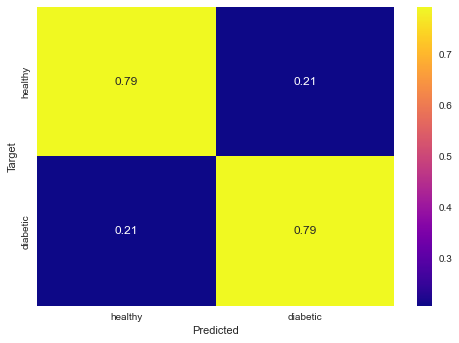


ROC Curve


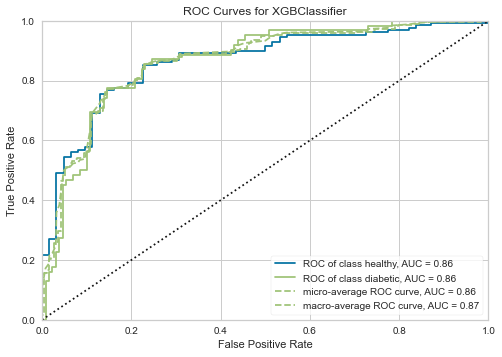

In [9]:
label_dict = {0: 'healthy', 1: 'diabetic'}
xgbc_eval = ML_evaluation(X_train, y_train, X_test, y_test, xgbc, label_dict)
xgbc_eval.eval_all()

In [10]:
xgbc_eval.save_model('../models/xgbc_model.json')